In [60]:
import pandas as pd
from sklearn.datasets import load_files

In [68]:
data = load_files('wkp_sorted')

sentences = []

for file in data.filenames:
    with open(file, 'r') as f:
        words = []
        for line in f:
            words.extend(line.split())
        first_15 = words[:15]
        sentence = ' '.join(first_15)
        sentences.append(sentence)


df = pd.DataFrame(sentences, columns=['Sentence'])
df['Label'] = data.target
df.to_csv('data.csv')

print(df.head())


                                            Sentence  Label
0  The Cardiff Roller Collective (CRoC) are a rol...     11
1  "Go! Pack Go!" is the fight song of the Green ...     11
2  Al-Machriq (English translation: The East) was...     14
3  Ajman International Airport (Arabic: مطار عجما...      0
4  Kapla is a construction set for children and a...      4


In [69]:
idx_to_label = {index:data['target_names'][index] for index in range(len(data['target_names']))}
idx_to_label

{0: 'Airports',
 1: 'Artists',
 2: 'Astronauts',
 3: 'Astronomical_objects',
 4: 'Building',
 5: 'City',
 6: 'Comics_characters',
 7: 'Companies',
 8: 'Foods',
 9: 'Monuments_and_memorials',
 10: 'Politicians',
 11: 'Sports_teams',
 12: 'Sportspeople',
 13: 'Transport',
 14: 'Universities_and_colleges',
 15: 'Written_communication'}

In [70]:
# Word2Vec
# from scipy.linalg.special_matrices import triu
from gensim.models import Word2Vec

# Load data
data = pd.read_csv('data.csv')
data.head()

,Unnamed: 0,Sentence,Label
0,0,The Cardiff Roller Collective (CRoC) are a rol...,11
1,1,"""Go! Pack Go!"" is the fight song of the Green ...",11
2,2,Al-Machriq (English translation: The East) was...,14
3,3,Ajman International Airport (Arabic: مطار عجما...,0
4,4,Kapla is a construction set for children and a...,4


In [64]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np

In [71]:

# Remove stopwords and punctuation
def remove_stopwords(sentence):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if not w in stop_words and w.isalpha()]
    return ' '.join(filtered_sentence)


data['Sentence'] = data['Sentence'].apply(remove_stopwords)
data.head()


d = []
for sentence in data['Sentence']:
    tok = []
    for word in word_tokenize(sentence):
        tok.append(word.lower())
    d.append(tok)


data['Tokenized'] = d
data.head()


,Unnamed: 0,Sentence,Label,Tokenized
0,0,The Cardiff Roller Collective CRoC roller spor...,11,"[the, cardiff, roller, collective, croc, rolle..."
1,1,Go Pack Go fight song Green Bay Packers first,11,"[go, pack, go, fight, song, green, bay, packer..."
2,2,English translation The East journal founded J...,14,"[english, translation, the, east, journal, fou..."
3,3,Ajman International Airport Arabic مطار عجمان ...,0,"[ajman, international, airport, arabic, مطار, ..."
4,4,Kapla construction set children adults The set...,4,"[kapla, construction, set, children, adults, t..."


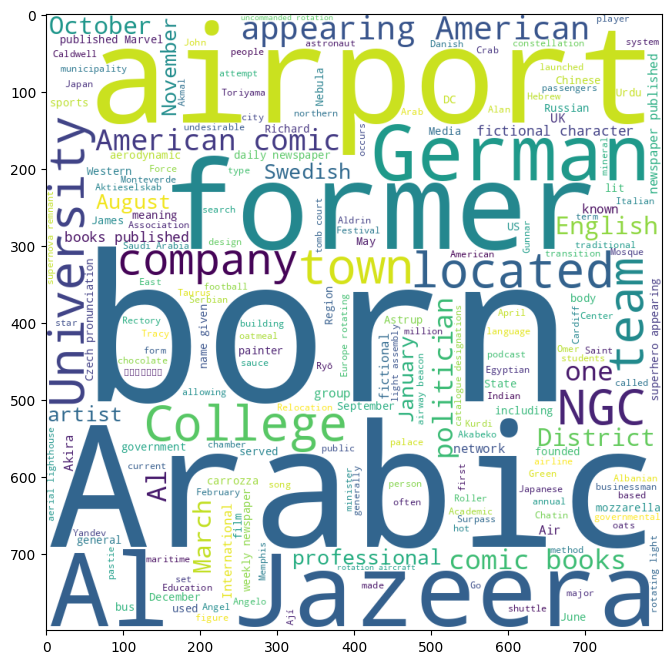

In [72]:
# word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(data['Sentence']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)

In [73]:
# Bag of words (sg=0 by default)
model = Word2Vec(data['Tokenized'], window=5, min_count=1, workers=4)
model.save('word2vec.model')

In [74]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

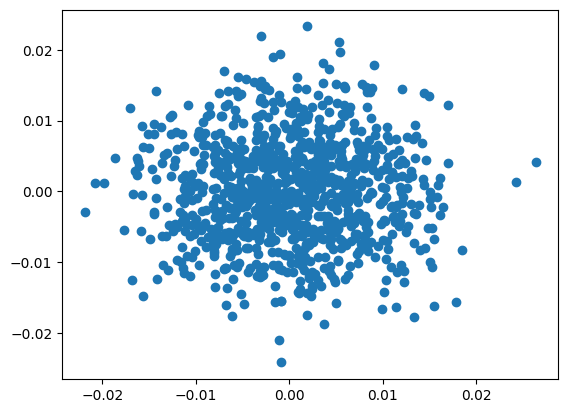

In [75]:
model = Word2Vec.load('word2vec.model')
word_vectors = model.wv

# reduce dimensions to 2
pca = PCA(n_components=2)
X = pca.fit_transform(word_vectors.vectors)

plt.scatter(X[:, 0], X[:, 1])

plt.show()

In [76]:
# Mean of word vectors
def mean_vector(words, model):
    # remove out of vocabulary words
    words = [word for word in words if word in model.wv]
    if len(words) >= 1:
        return np.mean(model.wv[words], axis=0)
    else:
        return []
    
data['Mean_bow'] = data['Tokenized'].apply(lambda x: mean_vector(x, model))
data.head()

,Unnamed: 0,Sentence,Label,Tokenized,Mean_bow
0,0,The Cardiff Roller Collective CRoC roller spor...,11,"[the, cardiff, roller, collective, croc, rolle...","[-0.0012059944, 0.00057655765, 0.0004546229, 0..."
1,1,Go Pack Go fight song Green Bay Packers first,11,"[go, pack, go, fight, song, green, bay, packer...","[0.0023387286, 0.0013184368, 0.0018480197, 0.0..."
2,2,English translation The East journal founded J...,14,"[english, translation, the, east, journal, fou...","[-0.0027212065, 0.0029319907, 0.002298687, -0...."
3,3,Ajman International Airport Arabic مطار عجمان ...,0,"[ajman, international, airport, arabic, مطار, ...","[0.00021810588, 0.001563381, 0.0033868733, -0...."
4,4,Kapla construction set children adults The set...,4,"[kapla, construction, set, children, adults, t...","[0.00047397893, 0.0011637352, 0.003106683, -0...."


In [77]:
def get_word_embedding(word):
    if word in word_vectors:
        return word_vectors[word]
    else:
        return None

print(get_word_embedding('born'))

[-0.00890673  0.00379804  0.00540526  0.00575971  0.00763622 -0.00658095
  0.00122391  0.00658505 -0.0030115  -0.0063162  -0.00065082 -0.00874107
 -0.00555437  0.00718041  0.00336234  0.00702587  0.00687371  0.00734968
 -0.00380908 -0.00092663  0.00237582 -0.00446699  0.00843669 -0.00990702
  0.00669856  0.00285942 -0.00501882  0.00410763 -0.00189099  0.00677669
  0.01033512 -0.00422731 -0.00051873 -0.00571397  0.00377256  0.00299096
  0.00694263  0.00593086  0.00926467  0.00885638  0.00796829 -0.00702697
 -0.00898831 -0.00040543 -0.00309702  0.00786289  0.00587621 -0.00149669
  0.00167903  0.00208491  0.0079796  -0.0097493  -0.00034765  0.00350405
 -0.00127819  0.00868779  0.00915704  0.00658064 -0.00100174  0.00772634
 -0.00840041  0.00323704 -0.00466167 -0.00516575  0.00320986  0.00556944
  0.00780339 -0.00559631  0.00730526  0.00683595 -0.00373499 -0.00877698
  0.00579526  0.00655104 -0.00045591 -0.00670554 -0.00705848 -0.00255048
  0.0050111  -0.00358926 -0.00948344  0.00392089  0

In [78]:
# Clustering
from sklearn.cluster import KMeans

X = np.array(data['Mean_bow'].tolist())
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
data['Cluster'] = kmeans.labels_
data.head()

,Unnamed: 0,Sentence,Label,Tokenized,Mean_bow,Cluster
0,0,The Cardiff Roller Collective CRoC roller spor...,11,"[the, cardiff, roller, collective, croc, rolle...","[-0.0012059944, 0.00057655765, 0.0004546229, 0...",2
1,1,Go Pack Go fight song Green Bay Packers first,11,"[go, pack, go, fight, song, green, bay, packer...","[0.0023387286, 0.0013184368, 0.0018480197, 0.0...",2
2,2,English translation The East journal founded J...,14,"[english, translation, the, east, journal, fou...","[-0.0027212065, 0.0029319907, 0.002298687, -0....",0
3,3,Ajman International Airport Arabic مطار عجمان ...,0,"[ajman, international, airport, arabic, مطار, ...","[0.00021810588, 0.001563381, 0.0033868733, -0....",1
4,4,Kapla construction set children adults The set...,4,"[kapla, construction, set, children, adults, t...","[0.00047397893, 0.0011637352, 0.003106683, -0....",2


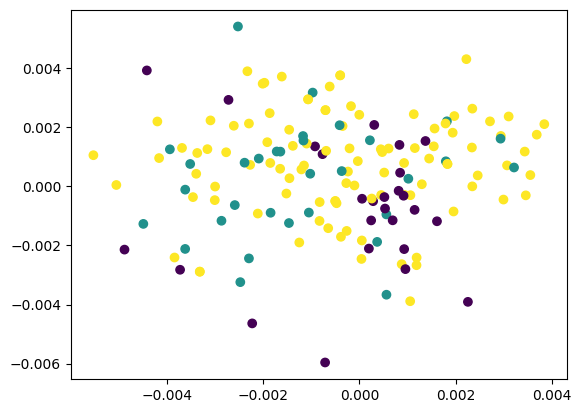

In [79]:
# plot clusters
plt.scatter(X[:, 0], X[:, 1], c=data['Cluster'])
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x')
plt.show()